# Part-of-speech tagging

#### Import libraries

In [3]:
from datetime import datetime
from functools import reduce
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow import keras
from tensorflow.keras import layers
from typing import List, Callable, Dict
import urllib.request  #  download files
import zipfile  #  unzip files

#### Define constant variables

In [4]:
train_path = './Dataset/train/'
val_path = './Dataset/val/'
test_path = './Dataset/test/'
dataset_folder = os.path.join(os.getcwd(), "OriginalDataset")
original_path = dataset_folder +'/dependency_treebank/'

embedding_dimension = 50


## Data pipeline

#### Download dataset

In [5]:
def download_dataset():
    dataset_folder = os.path.join(os.getcwd(), "OriginalDataset")

    if not os.path.exists(dataset_folder):
        os.makedirs(dataset_folder)

    url = 'https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip'

    dataset_path = os.path.join(dataset_folder, "dependency_treebank.zip")

    if not os.path.exists(dataset_path):
        urllib.request.urlretrieve(url, dataset_path)
        print("Successful download")

    with zipfile.ZipFile(dataset_path,"r") as zip_ref:
        zip_ref.extractall(dataset_folder)
    print("Successful extraction")

In [6]:
# Uncomment to download dataset
# download_dataset()

#### Split dataset

In [7]:
def split_dataset(train_path, val_path, test_path, original_path):
    if not os.path.exists(train_path):
        print("making directory")
        os.makedirs(train_path)
    if not os.path.exists(val_path):
        os.makedirs(val_path)
    if not os.path.exists(test_path):
        os.makedirs(test_path)

    original_dataset = os.listdir(original_path)
    
    original_dataset.sort()
    org_train = original_dataset[0:100]
    org_val = original_dataset[100:150]
    org_test = original_dataset[150:]

    for f in org_train:
        os.rename(original_path+f, train_path+f)
    for f in org_val:
        os.rename(original_path+f, val_path+f)
    for f in org_test:
        os.rename(original_path+f, test_path+f)
    print("Successful spilt")
        

In [8]:
# Uncomment the following line to split the dataset
# split_dataset(train_path, val_path, test_path, original_path)


#### Create dataframe

In [9]:
def create_dataframe(dataset_path: str):
    dataframe_rows = []
    documents = os.listdir(dataset_path)
    for document in documents:
        path = os.path.join(dataset_path, document)
        with open(path, 'r') as f:
            a = [[x for x in ln.split()] for ln in f]
        #---------------For splitting on sentence-------------------#
        sentence = []
        sentence_tag = []
        for x in a:
            if x!=[]:
                sentence.append(x[0])
                sentence_tag.append(x[1])
            else:
                dataframe_row = {
                    "text": sentence,
                    "POS": sentence_tag
                }
                sentence = []
                sentence_tag = []
                dataframe_rows.append(dataframe_row)
        #----------------------------------------------------------#
        #------------------To split on document--------------------#
        """
        a2 = [x for x in a if x != []] # OBS! Removing all empty lines in file so we can make an array
        arr = np.array(a2)
        text = list(arr[:, 0])
        tagg = list(arr[:, 1])
        #POStuple =  [tagg[x] for x in range(len(text))] #[(text[x], tagg[x]) for x in range(len(text))]
        document_id = int(document[4:8])
        dataframe_row = {
            "document_id": document_id,
            "text": text,
            "POS": tagg
        }
        dataframe_rows.append(dataframe_row)"""
        #----------------------------------------------------------#
    # transform the list of rows in a proper dataframe
    df = pd.DataFrame(dataframe_rows)
    df = df[["text", "POS"]]

    return df

In [10]:
df_train = create_dataframe(train_path)
df_val = create_dataframe(val_path)
df_test = create_dataframe(test_path)

## Clean and transform data

#### Clean text in data frame
We remove uncommon symbols and special characters and make all text to lower case.

In [11]:
REPLACE_BY_SPACE_RE = re.compile("[/(){}\[\]\|@,;]")
GOOD_SYMBOLS_RE = re.compile("[^0-9a-z #+_$]")

def lower(text: str) -> str:
    """
    Transforms given text to lower case.
    Example:
    Input: 'I really like New York city'
    Output: 'i really like new your city'
    """

    return text.lower()

def remove_special_characters(text: str) -> str:
    """
    Replaces special characters, such as paranthesis,
    with spacing character
    """

    return REPLACE_BY_SPACE_RE.sub('', text)

def filter_out_uncommon_symbols(text: str) -> str:
    """
    Removes any special character that is not in the
    good symbols list (check regular expression)
    """

    return GOOD_SYMBOLS_RE.sub('', text)

PREPROCESSING_PIPELINE = [
                          lower,
                          remove_special_characters,
                          filter_out_uncommon_symbols,
                          ]

def text_prepare(text,
                 filter_methods: List[Callable[[str], str]] = None) -> str:
    """
    Applies a list of pre-processing functions in sequence (reduce).
    Note that the order is important here!
    """

    filter_methods = filter_methods if filter_methods is not None else PREPROCESSING_PIPELINE

    new_row = [reduce(lambda txt, f: f(txt), filter_methods, x) for x in text]
    return [x for x in new_row if x!='']


# Replace each sentence with its pre-processed version
df_train['text'] = df_train['text'].apply(lambda txt: text_prepare(txt))
df_train['POS'] = df_train['POS'].apply(lambda txt: text_prepare(txt))
df_val['text'] = df_val['text'].apply(lambda txt: text_prepare(txt))
df_val['POS'] = df_val['POS'].apply(lambda txt: text_prepare(txt))
df_test['text'] = df_test['text'].apply(lambda txt: text_prepare(txt))
df_test['POS'] = df_test['POS'].apply(lambda txt: text_prepare(txt))

### Embed the words using GloVe embedding

#### Load glove model

In [12]:
import gensim
import gensim.downloader as gloader

def load_embedding_model(embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    # Check download
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model

In [13]:
embedding_model = load_embedding_model(embedding_dimension)

#### Tokenize data
We tokenize the data by using the keras tokenizer

In [14]:
def make_tokenizer(*vocabulary):
    # We do not want to remove the $ since this is part of some tags in POS tagging,
    # so we define the filter to not include $
    tokenizer = Tokenizer(filters='!"#%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')

    for v in vocabulary:
        v2 = sum(v.to_numpy().flatten(), [])
        tokenizer.fit_on_texts(v2)
    return tokenizer 


In [15]:
# Create tokenizer for all the words in the vocabulary
# Since in this case, where we already have all the documents, 
# and we can make a word index for every word in the vocabulary.
word_tokenizer = make_tokenizer(df_train["text"], df_val["text"], df_test["text"])

# Create tokenizer for all the tags
tag_tokenizer = make_tokenizer(df_train["POS"])

In [16]:
# Get size of word vocabulary and tag vocabulary
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1
TAG_VOCABULARY_SIZE = len(tag_tokenizer.word_index) + 1

#### Encode text (x) and tags (y)
We use the tokenizer to encode the text to the words their corresponding indices

In [17]:
# Encode train data
x_encoded_train = word_tokenizer.texts_to_sequences(df_train["text"])
y_encoded_train = tag_tokenizer.texts_to_sequences(df_train["POS"])

# Encode validation data
x_encoded_val = word_tokenizer.texts_to_sequences(df_val["text"])
y_encoded_val = tag_tokenizer.texts_to_sequences(df_val["POS"])

# Encode test data
x_encoded_test = word_tokenizer.texts_to_sequences(df_test["text"])
y_encoded_test = tag_tokenizer.texts_to_sequences(df_test["POS"])

#### Pad encoded sequences
The sequences needs to have the same length when they are sendt into the model. We therefore post-pad the sequences with zeros. 

In [18]:
def find_max_length(seqs):
    """
    Funciton for finding the maximum length of a sequence.
    This is used for padding the sequences
    """
    max_len = 0
    for seq in seqs:
        if len(seq) > max_len:
            max_len = len(seq)
    return max_len

# Get max sequence length
MAX_LENGTH = find_max_length(x_encoded_train)

In [19]:
def pad_idx_seqs(idx_seqs, max_seq_len):
    # Keras provides a convenient padding function; 
    padded_idxs = pad_sequences(sequences=idx_seqs, maxlen=max_seq_len, padding="post")
    return padded_idxs

In [20]:
# Pad train data
x_padded_train = pad_idx_seqs(x_encoded_train, MAX_LENGTH)
y_padded_train = pad_idx_seqs(y_encoded_train, MAX_LENGTH)

# Pad validation data
x_padded_val = pad_idx_seqs(x_encoded_val, MAX_LENGTH)
y_padded_val = pad_idx_seqs(y_encoded_val, MAX_LENGTH)

# Pad test data
x_padded_test = pad_idx_seqs(x_encoded_test, MAX_LENGTH)
y_padded_test = pad_idx_seqs(y_encoded_test, MAX_LENGTH)

#### Create embedding matrix
We use the pretrained glove model to create the embedding matrix.
If there are any OOV we create a random embedding vector. 

In [21]:
def create_embedding_matrix(embedding_model, embedding_dimension, VOCABULARY_SIZE, word_to_idx):
    embedding_matrix = np.zeros((VOCABULARY_SIZE, embedding_dimension), dtype=np.float32)
    for word, idx in word_to_idx.items():
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector
                                
    return embedding_matrix                             

In [22]:
embedding_matrix = create_embedding_matrix(embedding_model, embedding_dimension, VOCABULARY_SIZE, word_tokenizer.word_index)

#### Define x and y parameters
Y parameters must be converted from array of labeled data(from 0 to nb_classes - 1 ) to one-hot vector. 
This is done with the Keras to_categorical function

In [23]:
# Train data
x_train = x_padded_train
y_train = to_categorical(y_padded_train)

# Validation data
x_val = x_padded_val
y_val = to_categorical(y_padded_val, num_classes=TAG_VOCABULARY_SIZE)

# Test data
x_test = x_padded_test
# y_test is only used for predictions, and should therefore not be one hot encoded.
y_test = y_padded_test  

### Define functions for testing and evaluate the models

#### Define plotting functions

In [34]:
def plot_accuracy(model_callback, model_name='baseline_model'):
    plt.plot(model_callback.history['acc'])
    plt.plot(model_callback.history['val_acc'])
    plt.title(f'{model_name} accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc="lower right")
    plt.show()
    
def plot_loss(model_callback, model_name='baseline_model'):
    plt.plot(model_callback.history['loss'])
    plt.plot(model_callback.history['val_loss'])
    plt.title(f'{model_name} loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc="lower right")
    plt.show()

#### Functions for prediction

In [25]:
def predict(model: keras.Model, x, predicting_info):
    predictions = model.predict(x, **predicting_info)
    return predictions

#### Funcions for evaluation 

In [26]:
def remove_padding(y_test, y_pred_int):
    # Remove the padding classifications
    all_true_tags = [tag for sent_tags in y_test for tag in sent_tags]
    all_pred_tags = [tag for sent_tags in y_pred_int for tag in sent_tags]
    
    new_true_tags = []
    new_pred_tags = []
    for i, x in enumerate(all_true_tags):
        if x!= 0:
            new_true_tags.append(x)
            new_pred_tags.append(all_pred_tags[i])

    return new_true_tags, new_pred_tags

In [27]:
def plot_confusion_matrix(confusion_m, tagIdxList):
    # Plot the confusion matrix as a heat map
    df_cm = pd.DataFrame(confusion_m, index = tagIdxList,
                    columns = tagIdxList)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=False)

In [87]:
def evaluate(y_test, predictions, idx2tag):
    """
        Evaluates the model by computing accuracy, precission, recall and f1 score.
        Prints classification report
        Calculates and plots confusion_matrix
        Inputs:
            y_test: ground truth for test set
            predicitons: perdicitons calculated by the model
            idx2tag: Dicitonary of all tags and corresponding indexes. 
    """
    y_pred_int = np.argmax(predictions, axis=2)
    new_true_tags, new_pred_tags = remove_padding(y_test, y_pred_int)

    accuracy = accuracy_score(y_true=new_true_tags, y_pred=new_pred_tags)
    precision = precision_score(y_true=new_true_tags, y_pred=new_pred_tags, average='weighted', zero_division=0)
    recall = recall_score(y_true=new_true_tags, y_pred=new_pred_tags, average='weighted', zero_division=0)
    f1 = f1_score(y_true=new_true_tags, y_pred=new_pred_tags, average='weighted', zero_division=0)

    print("ACCURACY: {:.3f}".format(accuracy))
    print("PRECISION: {:.3f}".format(precision))
    print("RECALL: {:.3f}".format(recall))
    print("F1: {:.3f}".format(f1))
    
    tags = list(idx2tag.values())
    tagIdxList = list(idx2tag.keys())
    report = classification_report(new_true_tags, new_pred_tags, labels=tagIdxList, zero_division=0)
    print(report)

    confusion_m = confusion_matrix(new_true_tags, new_pred_tags, labels=tagIdxList)
    print(confusion_m)

    plot_confusion_matrix(confusion_m, tags)

#### Funciton for saving the models

In [29]:
def save_model(model, model_type, dir='models'):
    '''
        Saves model naming it according to sentence embedding merge type and time stamp.
    '''
    now = datetime.now()
    dt_string = now.strftime("%d_%m_%Y_%H:%M:%S")
    model_name = f'model_{model_type}_{dt_string}'
    path = f'{dir}/{model_name}'
    model.save(path)

## Creating, running and testing the models

In [38]:
BATCH_SIZE = 32
EPOCHS = 10
ACTIVATION = 'softmax'

### Baseline model

##### two layers architecture: a Bidirectional LSTM layer and a Dense/Fully-Connected layer on top

#### Create baseline model

In [39]:
def create_baseline_model(units_LSTM, activation):
    bidirect_model = keras.Sequential()
    bidirect_model.add(layers.Embedding(input_dim = VOCABULARY_SIZE,
                                 output_dim    = embedding_dimension,
                                 input_length  = find_max_length(x_train),
                                 weights       = [embedding_matrix],
                                 trainable = False,
                                 mask_zero = True
                                ))
    bidirect_model.add(layers.Bidirectional(layers.LSTM(units_LSTM, return_sequences=True)))
    #bidirect_model.add(layers.TimeDistributed(layers.Dense(len(tag_to_idx), activation='softmax')))
    bidirect_model.add(layers.Dense(TAG_VOCABULARY_SIZE, activation=activation))
    
    return bidirect_model

In [40]:
baseline_model = create_baseline_model(64, ACTIVATION)
baseline_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 186, 50)           526000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 186, 128)         58880     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 186, 40)           5160      
                                                                 
Total params: 590,040
Trainable params: 64,040
Non-trainable params: 526,000
_________________________________________________________________


#### Train baseline model

In [41]:
baseline_model.compile(loss="mse",
              optimizer="Adam",
              metrics=['mae', "acc"])
baseline_training = baseline_model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), batch_size=BATCH_SIZE,  epochs=EPOCHS)

# Save the model when training is finished
save_model(baseline_model, 'baseline_model')

Epoch 1/10
59/59 [==============================] - 21s 186ms/step - loss: 0.0027 - mae: 0.0473 - acc: 0.1534 - val_loss: 0.0026 - val_mae: 0.0451 - val_acc: 0.2917
Epoch 2/10
59/59 [==============================] - 10s 166ms/step - loss: 0.0024 - mae: 0.0426 - acc: 0.3540 - val_loss: 0.0022 - val_mae: 0.0400 - val_acc: 0.4139
Epoch 3/10
59/59 [==============================] - 10s 161ms/step - loss: 0.0020 - mae: 0.0367 - acc: 0.4635 - val_loss: 0.0019 - val_mae: 0.0343 - val_acc: 0.5115
Epoch 4/10
59/59 [==============================] - 9s 151ms/step - loss: 0.0017 - mae: 0.0321 - acc: 0.5593 - val_loss: 0.0017 - val_mae: 0.0306 - val_acc: 0.5803
Epoch 5/10
59/59 [==============================] - 9s 152ms/step - loss: 0.0015 - mae: 0.0285 - acc: 0.6241 - val_loss: 0.0015 - val_mae: 0.0276 - val_acc: 0.6212
Epoch 6/10
59/59 [==============================] - 9s 161ms/step - loss: 0.0014 - mae: 0.0262 - acc: 0.6521 - val_loss: 0.0014 - val_mae: 0.0261 - val_acc: 0.6377
Epoch 7/10
59

INFO:tensorflow:Assets written to: models/model_baseline_model_02_12_2021_14:27:29/assets


INFO:tensorflow:Assets written to: models/model_baseline_model_02_12_2021_14:27:29/assets


#### Plot results

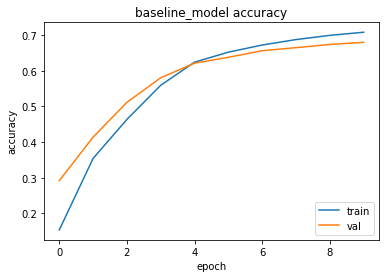

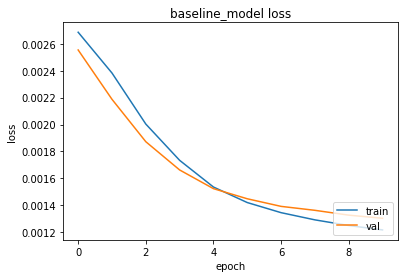

In [43]:
plot_accuracy(baseline_training, 'baseline_model')
plot_loss(baseline_training, 'baseline_model')

#### Calculate predicitons for test set

In [44]:
predictions = predict(baseline_model, x_test, {'batch_size': BATCH_SIZE})

#### Evaluate model
Evaluate how well the models predicitons for the test set where

ACCURACY: 0.681
PRECISION: 0.620
RECALL: 0.681
F1: 0.648
              precision    recall  f1-score   support

           1       0.64      0.74      0.69      2207
           2       0.67      0.79      0.73      1368
           3       0.73      0.85      0.79      1521
           4       0.86      0.89      0.88      1260
           5       0.65      0.69      0.67       886
           6       0.47      0.48      0.48       859
           7       0.70      0.63      0.66       600
           8       0.47      0.46      0.47       357
           9       0.78      0.81      0.79       791
          10       0.65      0.86      0.74       383
          11       0.76      0.76      0.76       334
          12       0.67      0.72      0.70       258
          13       0.49      0.48      0.49       331
          14       0.78      0.92      0.84       361
          15       0.77      0.93      0.84       181
          16       0.00      0.00      0.00       209
          17       0.51 

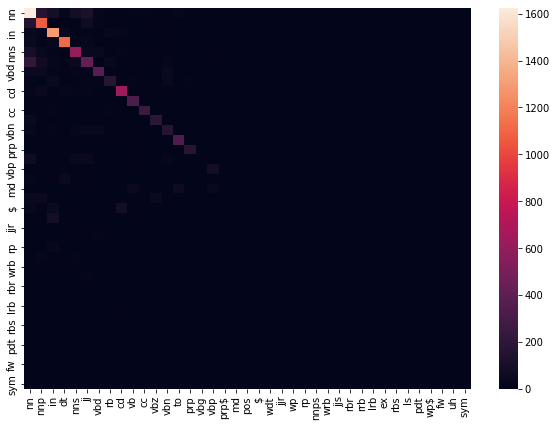

In [88]:
evaluate(y_test, predictions, tag_tokenizer.index_word)

## Other models
Experiment doing small modifications to the baseline model

### Gru model
Uses a GRU instead of the LSTM layer

#### Create GRU model

In [56]:
def create_gru_model(units_gru, activation):
    gru_model = keras.Sequential()
    gru_model.add(layers.Embedding(input_dim = VOCABULARY_SIZE,
                                 output_dim    = embedding_dimension,
                                 input_length  = find_max_length(x_train),
                                 weights       = [embedding_matrix],
                                 trainable = False,
                                 mask_zero = True
                                ))
    gru_model.add(layers.Bidirectional(layers.GRU(units_gru, return_sequences=True)))
    #bidirect_model.add(layers.TimeDistributed(layers.Dense(len(tag_to_idx), activation='softmax')))
    gru_model.add(layers.Dense(TAG_VOCABULARY_SIZE, activation=activation))
    
    return gru_model

In [57]:
gru_model = create_gru_model(64, ACTIVATION)
gru_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 186, 50)           526000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 186, 128)         44544     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 186, 40)           5160      
                                                                 
Total params: 575,704
Trainable params: 49,704
Non-trainable params: 526,000
_________________________________________________________________


#### Train gru model

In [58]:
gru_model.compile(loss="mse",
              optimizer="Adam",
              metrics=['mae', "acc"])
gru_training = gru_model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), batch_size=BATCH_SIZE,  epochs=EPOCHS)

# Save the model when training is finished
save_model(gru_model, 'gru_model')

Epoch 1/10
59/59 [==============================] - 22s 239ms/step - loss: 0.0026 - mae: 0.0460 - acc: 0.2121 - val_loss: 0.0023 - val_mae: 0.0421 - val_acc: 0.3586
Epoch 2/10
59/59 [==============================] - 9s 153ms/step - loss: 0.0021 - mae: 0.0382 - acc: 0.4343 - val_loss: 0.0019 - val_mae: 0.0351 - val_acc: 0.4943
Epoch 3/10
59/59 [==============================] - 9s 146ms/step - loss: 0.0018 - mae: 0.0322 - acc: 0.5472 - val_loss: 0.0017 - val_mae: 0.0303 - val_acc: 0.5811
Epoch 4/10
59/59 [==============================] - 10s 166ms/step - loss: 0.0015 - mae: 0.0278 - acc: 0.6235 - val_loss: 0.0015 - val_mae: 0.0270 - val_acc: 0.6264
Epoch 5/10
59/59 [==============================] - 10s 171ms/step - loss: 0.0014 - mae: 0.0252 - acc: 0.6637 - val_loss: 0.0014 - val_mae: 0.0252 - val_acc: 0.6664
Epoch 6/10
59/59 [==============================] - 11s 189ms/step - loss: 0.0013 - mae: 0.0233 - acc: 0.6953 - val_loss: 0.0013 - val_mae: 0.0236 - val_acc: 0.6827
Epoch 7/10
5

INFO:tensorflow:Assets written to: models/model_gru_model_02_12_2021_14:33:15/assets


INFO:tensorflow:Assets written to: models/model_gru_model_02_12_2021_14:33:15/assets


#### Plot results

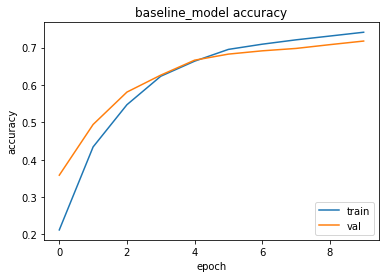

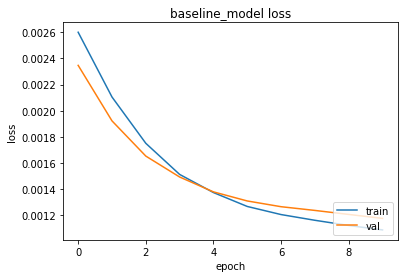

In [59]:
plot_accuracy(gru_training)
plot_loss(gru_training)

#### Calculate predicitons for test set

In [60]:
predictions_gru = predict(gru_model, x_test, {'batch_size': BATCH_SIZE})

#### Evaluate model
Evaluate how well the models predicitons for the test set where

ACCURACY: 0.724
PRECISION: 0.697
RECALL: 0.724
F1: 0.709
              precision    recall  f1-score   support

           1       0.69      0.71      0.70      2207
           2       0.68      0.81      0.74      1368
           3       0.77      0.84      0.80      1521
           4       0.88      0.89      0.89      1260
           5       0.65      0.75      0.70       886
           6       0.53      0.50      0.51       859
           7       0.71      0.67      0.69       600
           8       0.50      0.52      0.51       357
           9       0.84      0.83      0.83       791
          10       0.73      0.87      0.79       383
          11       0.77      0.76      0.77       334
          12       0.83      0.75      0.79       258
          13       0.66      0.50      0.57       331
          14       0.91      0.92      0.91       361
          15       0.78      0.94      0.85       181
          16       0.45      0.25      0.32       209
          17       0.66 

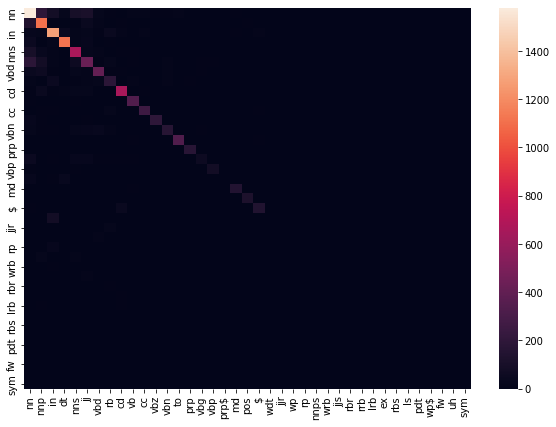

In [89]:
evaluate(y_test, predictions_gru, tag_tokenizer.index_word)

### Two LSTM layers
Adding an additional LSTM layer to the baseline model.

#### Create model

In [62]:
def create_doubleLSTM_model(units_LSTM1, units_LSTM2, activation):
    doubleLSTM_model = keras.Sequential()
    doubleLSTM_model.add(layers.Embedding(input_dim = VOCABULARY_SIZE,
                                 output_dim    = embedding_dimension,
                                 input_length  = find_max_length(x_train),
                                 weights       = [embedding_matrix],
                                 trainable     = False,
                                 mask_zero = True
                                ))
    doubleLSTM_model.add(layers.Bidirectional(layers.LSTM(units_LSTM1, return_sequences=True)))
    doubleLSTM_model.add(layers.Bidirectional(layers.LSTM(units_LSTM2, return_sequences=True)))
    #bidirect_model.add(layers.TimeDistributed(layers.Dense(len(tag_to_idx), activation='softmax')))
    doubleLSTM_model.add(layers.Dense(TAG_VOCABULARY_SIZE, activation=activation))
    
    return doubleLSTM_model

In [63]:
doubleLSTM_model = create_doubleLSTM_model(64, 64, ACTIVATION)
doubleLSTM_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 186, 50)           526000    
                                                                 
 bidirectional_5 (Bidirectio  (None, 186, 128)         58880     
 nal)                                                            
                                                                 
 bidirectional_6 (Bidirectio  (None, 186, 128)         98816     
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 186, 40)           5160      
                                                                 
Total params: 688,856
Trainable params: 162,856
Non-trainable params: 526,000
_________________________________________________________________


#### Train model 

In [64]:
doubleLSTM_model.compile(loss="mse",
              optimizer="Adam",
              metrics=['mae', "acc"])
doubleLSTM_training = doubleLSTM_model.fit(x=x_train, batch_size=BATCH_SIZE, y=y_train, epochs=EPOCHS, validation_data=(x_val, y_val))

# Save the model when training is finished
save_model(doubleLSTM_model, 'doubleLSTM_model')

Epoch 1/10
59/59 [==============================] - 55s 645ms/step - loss: 0.0027 - mae: 0.0470 - acc: 0.1522 - val_loss: 0.0026 - val_mae: 0.0458 - val_acc: 0.1903
Epoch 2/10
59/59 [==============================] - 26s 446ms/step - loss: 0.0025 - mae: 0.0445 - acc: 0.2461 - val_loss: 0.0025 - val_mae: 0.0433 - val_acc: 0.2888
Epoch 3/10
59/59 [==============================] - 28s 467ms/step - loss: 0.0023 - mae: 0.0403 - acc: 0.3700 - val_loss: 0.0021 - val_mae: 0.0369 - val_acc: 0.4320
Epoch 4/10
59/59 [==============================] - 28s 471ms/step - loss: 0.0019 - mae: 0.0345 - acc: 0.4755 - val_loss: 0.0018 - val_mae: 0.0334 - val_acc: 0.5167
Epoch 5/10
59/59 [==============================] - 28s 482ms/step - loss: 0.0017 - mae: 0.0308 - acc: 0.5674 - val_loss: 0.0016 - val_mae: 0.0292 - val_acc: 0.5882
Epoch 6/10
59/59 [==============================] - 32s 537ms/step - loss: 0.0015 - mae: 0.0270 - acc: 0.6309 - val_loss: 0.0015 - val_mae: 0.0265 - val_acc: 0.6239
Epoch 7/10

INFO:tensorflow:Assets written to: models/model_doubleLSTM_model_02_12_2021_14:38:29/assets


INFO:tensorflow:Assets written to: models/model_doubleLSTM_model_02_12_2021_14:38:29/assets


#### Plot results

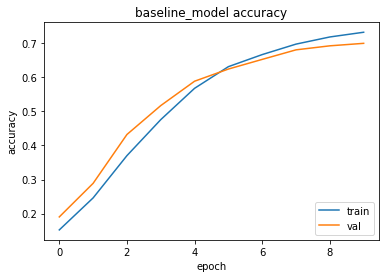

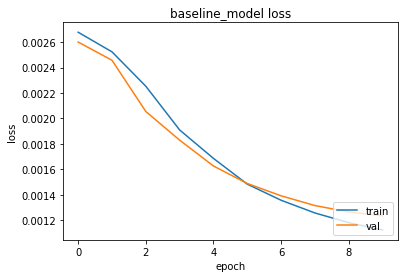

In [65]:
plot_accuracy(doubleLSTM_training)
plot_loss(doubleLSTM_training)

#### Calculate predicitons for test set

In [66]:
predictions_doubleLSTM = predict(doubleLSTM_model, x_test, {'batch_size': BATCH_SIZE})

#### Evaluate model
Evaluate how well the models predicitons for the test set where

ACCURACY: 0.700
PRECISION: 0.660
RECALL: 0.700
F1: 0.676
              precision    recall  f1-score   support

           1       0.73      0.67      0.70      2207
           2       0.70      0.82      0.76      1368
           3       0.78      0.84      0.81      1521
           4       0.89      0.89      0.89      1260
           5       0.66      0.72      0.69       886
           6       0.48      0.58      0.53       859
           7       0.72      0.67      0.69       600
           8       0.43      0.55      0.48       357
           9       0.71      0.83      0.76       791
          10       0.67      0.87      0.76       383
          11       0.78      0.75      0.77       334
          12       0.65      0.71      0.68       258
          13       0.45      0.57      0.50       331
          14       0.78      0.94      0.85       361
          15       0.74      0.92      0.82       181
          16       0.39      0.09      0.14       209
          17       0.69 

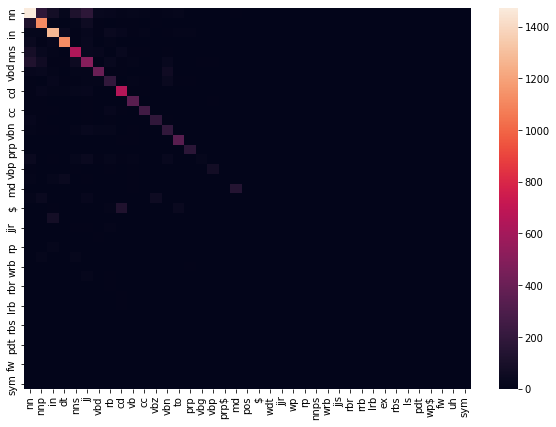

In [90]:
evaluate(y_test, predictions_doubleLSTM, tag_tokenizer.index_word)

### Two dense layers
Add an additional dense layer to the baseline model.

#### Create model

In [68]:
def create_doubledense_model(units_LSTM, units_dense, activation):
    doubledense_model = keras.Sequential()
    doubledense_model.add(layers.Embedding(input_dim = VOCABULARY_SIZE,
                                 output_dim    = embedding_dimension,
                                 input_length  = find_max_length(x_train),
                                 weights       = [embedding_matrix],
                                 trainable = False, 
                                 mask_zero = True
                                ))
    doubledense_model.add(layers.Bidirectional(layers.LSTM(units_LSTM, return_sequences=True)))
    doubledense_model.add(layers.Dense(units_dense))
    #bidirect_model.add(layers.TimeDistributed(layers.Dense(len(tag_to_idx), activation='softmax')))
    doubledense_model.add(layers.Dense(TAG_VOCABULARY_SIZE, activation=activation))
    
    return doubledense_model

In [69]:
doubleDense_model = create_doubledense_model(64, 64, ACTIVATION)
doubleDense_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 186, 50)           526000    
                                                                 
 bidirectional_7 (Bidirectio  (None, 186, 128)         58880     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 186, 64)           8256      
                                                                 
 dense_7 (Dense)             (None, 186, 40)           2600      
                                                                 
Total params: 595,736
Trainable params: 69,736
Non-trainable params: 526,000
_________________________________________________________________


#### Train model

In [70]:
doubleDense_model.compile(loss="mse",
              optimizer="Adam",
              metrics=['mae', "acc"])
doubleDense_training = doubleDense_model.fit(x=x_train, batch_size=BATCH_SIZE, y=y_train, epochs=EPOCHS, validation_data=(x_val, y_val))

# Save the model when training is finished
save_model(doubleDense_model, 'doubleDense_model')

Epoch 1/10
59/59 [==============================] - 22s 210ms/step - loss: 0.0026 - mae: 0.0460 - acc: 0.2123 - val_loss: 0.0024 - val_mae: 0.0429 - val_acc: 0.3402
Epoch 2/10
59/59 [==============================] - 10s 161ms/step - loss: 0.0022 - mae: 0.0387 - acc: 0.4098 - val_loss: 0.0019 - val_mae: 0.0356 - val_acc: 0.4667
Epoch 3/10
59/59 [==============================] - 9s 155ms/step - loss: 0.0018 - mae: 0.0324 - acc: 0.5249 - val_loss: 0.0017 - val_mae: 0.0304 - val_acc: 0.5605
Epoch 4/10
59/59 [==============================] - 10s 171ms/step - loss: 0.0015 - mae: 0.0277 - acc: 0.6149 - val_loss: 0.0015 - val_mae: 0.0264 - val_acc: 0.6182
Epoch 5/10
59/59 [==============================] - 9s 157ms/step - loss: 0.0014 - mae: 0.0246 - acc: 0.6567 - val_loss: 0.0014 - val_mae: 0.0245 - val_acc: 0.6427
Epoch 6/10
59/59 [==============================] - 9s 157ms/step - loss: 0.0013 - mae: 0.0230 - acc: 0.6810 - val_loss: 0.0014 - val_mae: 0.0236 - val_acc: 0.6664
Epoch 7/10
59

INFO:tensorflow:Assets written to: models/model_doubleDense_model_02_12_2021_14:41:44/assets


INFO:tensorflow:Assets written to: models/model_doubleDense_model_02_12_2021_14:41:44/assets


#### Plot results

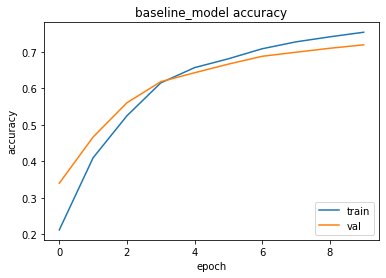

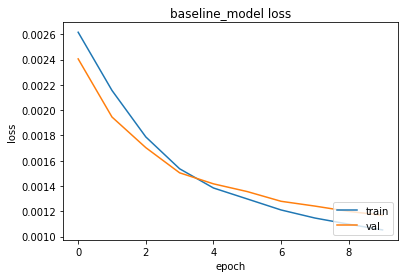

In [71]:
plot_accuracy(doubleDense_training)
plot_loss(doubleDense_training)

#### Calculate predicitons for test set

In [72]:
predictions_doubleDense = predict(doubleDense_model, x_test, {'batch_size': BATCH_SIZE})

#### Evaluate model
Evaluate how well the models predicitons for the test set where

ACCURACY: 0.727
PRECISION: 0.693
RECALL: 0.727
F1: 0.708
              precision    recall  f1-score   support

           1       0.69      0.75      0.72      2207
           2       0.72      0.80      0.76      1368
           3       0.79      0.84      0.82      1521
           4       0.91      0.90      0.91      1260
           5       0.72      0.76      0.74       886
           6       0.52      0.56      0.54       859
           7       0.74      0.68      0.71       600
           8       0.51      0.55      0.53       357
           9       0.83      0.83      0.83       791
          10       0.66      0.88      0.76       383
          11       0.77      0.76      0.76       334
          12       0.61      0.76      0.68       258
          13       0.53      0.44      0.49       331
          14       0.90      0.92      0.91       361
          15       0.77      0.94      0.85       181
          16       0.45      0.20      0.27       209
          17       0.68 

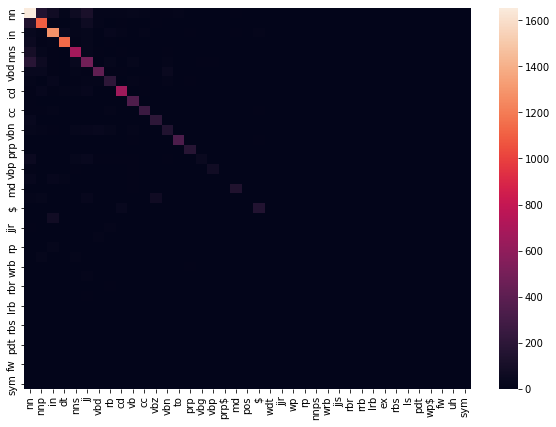

In [91]:
evaluate(y_test, predictions_doubleDense, tag_tokenizer.index_word)